# Kikuchipy bcf2hdf5 Converter

Author: Lukas Grünewald, Karlsruhe Insitute of Technology (KIT)  
Version: 0.3  
Date: 24.06.2024  

### Purpose
This notebook extracts the EBSD/TKD/4D-STEM diffraction patterns from a hdf5 file generated generated from the `bcf2hdf5` program from https://github.com/BlueQuartzSoftware/BCFTools.  
It extracts and reshapes the data, which is then saved as a Kikuchipy-compatible .hspy/.h5./zspy file for storage and later use with Kikuchipy EBSD processing.

### Requirements

The input file is a hdf5 file generated by `bcf2hdf5`. See this [guide](https://lukmuk.github.io//posts/2024/05/blog-ebsd-bcf/) how to generate this hdf5 from a Bruker bcf file.

The required Python packages and version used to run this notebook are listed below using ```watermark```.  
A conda environment with the following packages should work:
+  kikuchipy
+  hyperspy
+  pyxem (only for 4D-STEM-like signals, e.g., 4D-STEM-in-SEM or spot-like TKD patterns)
+  jupyterlab
+  ipympl (interactive inline plots with widget matplotlib backend)
+  watermark (to document package versions)

In [1]:
%load_ext watermark
%matplotlib widget
    
import numpy as np
import matplotlib.pyplot as plt

import hyperspy.api as hs
import kikuchipy as kp
import h5py
from tifffile import imwrite

In [2]:
%watermark -i -v -u -m --iversions

Last updated: 2024-06-25T09:33:51.629639+02:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

Compiler    : MSC v.1937 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 13, GenuineIntel
CPU cores   : 16
Architecture: 64bit

matplotlib: 3.8.2
h5py      : 3.10.0
numpy     : 1.26.3
kikuchipy : 0.9.0
hyperspy  : 1.7.6



## 0. Load and inspect the hdf5 content
We load the hdf5 using `h5py`.  
For a quick look into the metadata or other data stored in the hdf5, one can also use the [HDFView](https://github.com/HDFGroup/hdfview/releases) GUI.

In [3]:
# Load hdf5 generated from bcf2hdf5 using h5py
f = h5py.File('data/input.hdf5', 'r')
f.keys()

<KeysViewHDF5 ['All']>

In [4]:
# Load dataset
dset = f[list(f.keys())[0]]

In [5]:
# Inspect groups
list(dset)

['EBSD']

In [6]:
# Subgroups of EBSD
list(dset['EBSD'])

['Data', 'Header', 'SEM']

In [7]:
# Subgroups of EBSD-SEM
list(dset['EBSD']['SEM'])

['SEM IX',
 'SEM IY',
 'SEM Image',
 'SEM ImageHeight',
 'SEM ImageWidth',
 'SEM KV',
 'SEM Magnification',
 'SEM WD',
 'SEM XResolution',
 'SEM YResolution']

The data can be extracted as numpy arrays can be accessed by adding `[:]`, e.g., the beam energy:

In [8]:
dset['EBSD']['SEM']['SEM KV'][:]

array([30.])

In [9]:
# Subgroups of EBSD-Header
list(dset['EBSD']['Header'])

['Date',
 'Grid Type',
 'KV',
 'MADMax',
 'Magnification',
 'MinIndexedBands',
 'NCOLS',
 'NPoints',
 'NROWS',
 'OriginalFile',
 'PCX',
 'PatternHeight',
 'PatternWidth',
 'Phases',
 'PixelByteCount',
 'SEM Image',
 'SEPixelSizeX',
 'SEPixelSizeY',
 'SampleTilt',
 'Time',
 'TopClip',
 'WD',
 'XSTEP',
 'YSTEP',
 'ZOffset']

In [10]:
# Subgroups of EBSD-Data
list(dset['EBSD']['Data'])

['MAD',
 'NIndexedBands',
 'PCX',
 'PCY',
 'PHI',
 'Phase',
 'RadonBandCount',
 'RadonQuality',
 'RawPatterns',
 'X BEAM',
 'Y BEAM',
 'phi1',
 'phi2']

In [11]:
# Strings can be accessed via .asstr()[()], https://github.com/h5py/h5py/issues/1779
# E.g.
dset['EBSD']['Header']['Date'].asstr()[()]

'5.12.2018'

In [12]:
dset['EBSD']['Header']['Time'].asstr()[()]

'12:56:42'

## 1. Get SEM Overview Image

In [13]:
# SEM image
dset['EBSD']['SEM']['SEM Image']

<HDF5 dataset "SEM Image": shape (682, 1024), type "<u2">

In [14]:
# Get data as numpy array
sem_img = dset['EBSD']['SEM']['SEM Image'][:]
sem_img.shape

(682, 1024)

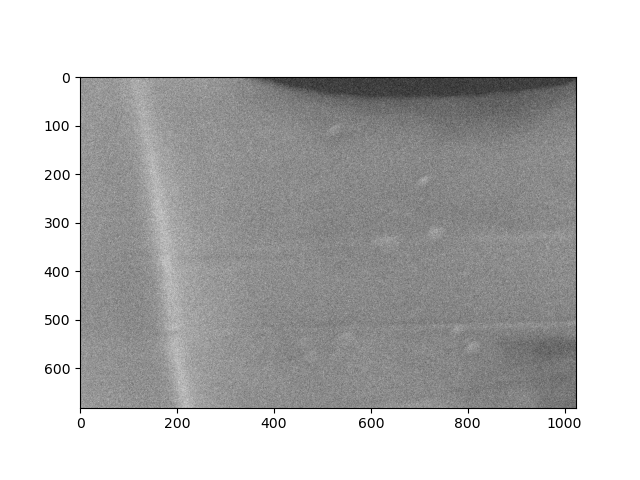

In [15]:
fig, ax = plt.subplots()
ax.imshow(sem_img, cmap='gray')

In [16]:
# Extract pixelsize
pixelsize = dset['EBSD']['SEM']['SEM XResolution'][:][0] # seems to be in µm
unit = 'um'
print(f'Pixel size: {pixelsize:.6f} {unit}')

Pixel size: 0.001703 um


In [17]:
# Save as TIFF image, e.g., for Fiji/ImageJ
imwrite('SEM_image.tif', sem_img, imagej=True, 
        resolution=(1./pixelsize, 1./pixelsize), 
        metadata={'unit': unit})

## 2. Get EBSPs

In [18]:
# Get raw patterns
patterns = dset['EBSD']['Data']['RawPatterns'][:]
patterns.shape

(174592, 200, 200)

The pattern positions are loaded as a 1D array.  
The EBSPs with the size of the EBSD camera readout (including any binning).  


The length of the first number matches the pixels in the SEM image:

In [19]:
x_scan = dset['EBSD']['Header']['NCOLS'][:][0]
y_scan = dset['EBSD']['Header']['NROWS'][:][0]
y_ebsd = dset['EBSD']['Header']['PatternHeight'][:][0]
x_ebsd = dset['EBSD']['Header']['PatternWidth'][:][0]

In [20]:
print('X scan:', x_scan)

X scan: 512


In [21]:
print('Y scan:', y_scan)

Y scan: 341


In [22]:
print('Total number of scan positions:', x_scan*y_scan)

Total number of scan positions: 174592


This means that the hdf5 contains a pattern for each position in the SEM scan, even when a subregion/ROI was selected for EBSD.

Let's reshape the signal using the known SEM scan size and pattern size from the metadata:

In [23]:
# Reshape scan position 1D array to a proper 2D array reflecting the raster scan
# Note that numpy uses (rows, cols), which is (y, x) for images
patterns = patterns.reshape((y_scan, x_scan, y_ebsd, x_ebsd))
patterns.shape

(341, 512, 200, 200)

If an ROI was used:  
We can inspect the actual EBSD pattern area in the image by simply summing up the EBSD pattern intensity at each scan position.  
"Not-scanned" areas will have 0 intensity.  

However, there is also a possibility for "invalid" patterns, where bcf2hdf5 reads out a static image for scan positions "below" a used ROI. This will be removed further below.

In [24]:
summed = np.sum(patterns, axis=(2,3)) # sum EBSD pattern intensity at each scan position

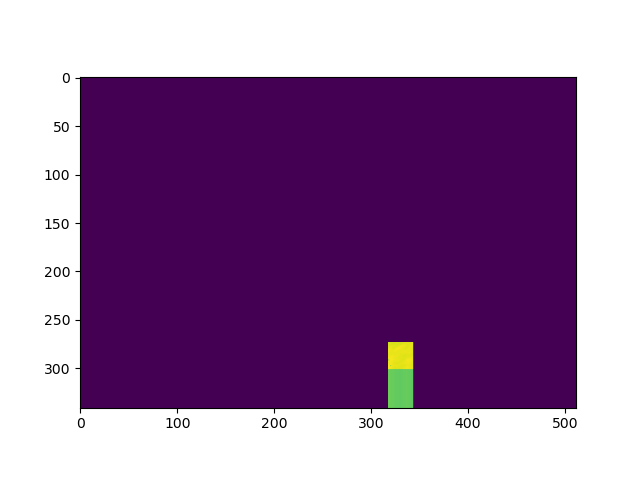

In [25]:
fig, ax = plt.subplots()
ax.imshow(summed)

## 3. Convert to Kikuchipy/HyperSpy signals and reduce to valid patterns
We convert the data to a Kikuchipy/HyperSpy signal for use in data processing.  
**Note:** At the moment we only save spatial calibration (pixel size) as metadata, but the rest from the original hdf5 may be added here.

In [26]:
# Convert to Hyperspy signal, then set it to EBSD type
# For 4D-STEM/TKD data, have a look at pyxem and use s.set_signal_type("electron_diffraction")

s = hs.signals.Signal2D(patterns)
s.set_signal_type('EBSD')
#s.set_signal_type("electron_diffraction") # for TKD/4D-STEM patterns 

In [27]:
s

<EBSD, title: , dimensions: (512, 341|200, 200)>

We can now conveniently inspect the diffraction patterns/EBSPs:

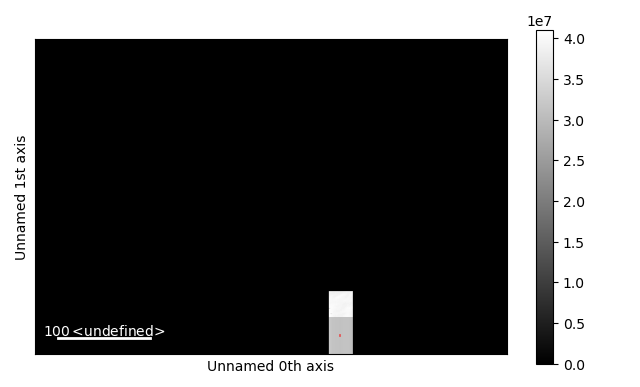

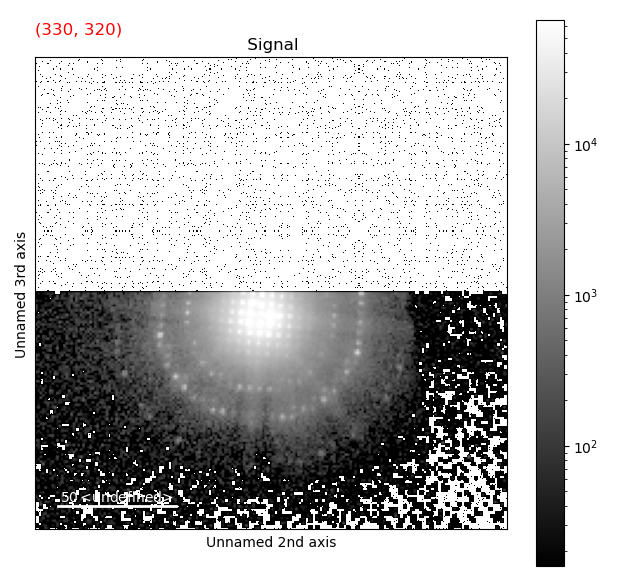

In [59]:
# Interactively inspect EBSD patterns, use arrows keys to move the red navigator
#s.plot()
s.plot(norm='log') # log intensity scaling

**Important:** If an ROI was used to collect EBSD/TKD patterns, there might be invalid patterns "below" the ROI.  
These might be fixed in a future update to bcf2hdf5 (?), but for now they only show "half" of the EBSP signal area and mostly a static image.

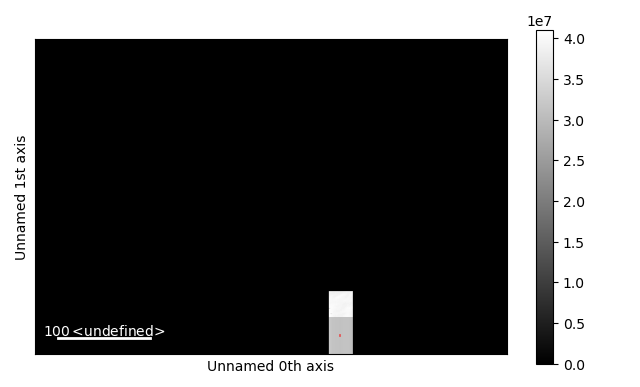

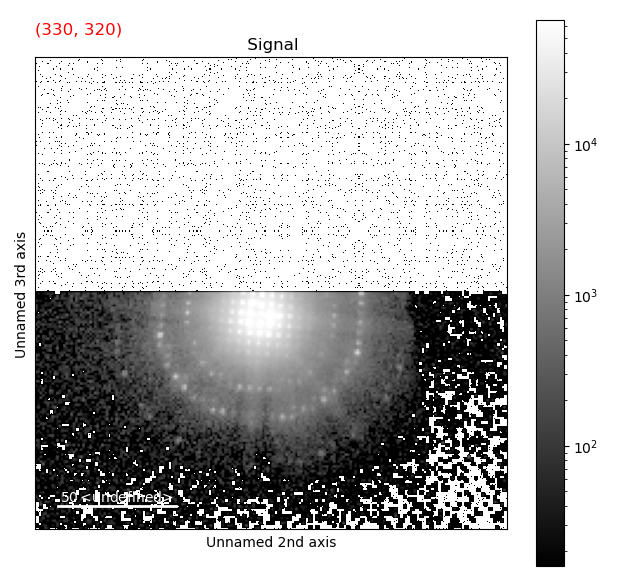

In [58]:
# Interactively inspect EBSD patterns, use arrows keys to move the red navigator
#s.plot()
s.plot(norm='log')

### Remove invalid patterns by masking
The invalid diffraction patterns have 0 values in the top half of the signal (= patterns) and a random fixed signal in the lower part.  
Summing up the top half of the patterns will provide a mask for the valid patterns.  
This approach should work even for non-rectangular ROIs.

Alternatively, for rectangular ROIs one can crop the navigation dimension to the desired region. 

In [28]:
s.axes_manager.signal_shape

(200, 200)

This next cell sums only the top half of the EBSD patterns, which are 0. The next image thus *should* only show the actual patterns! 

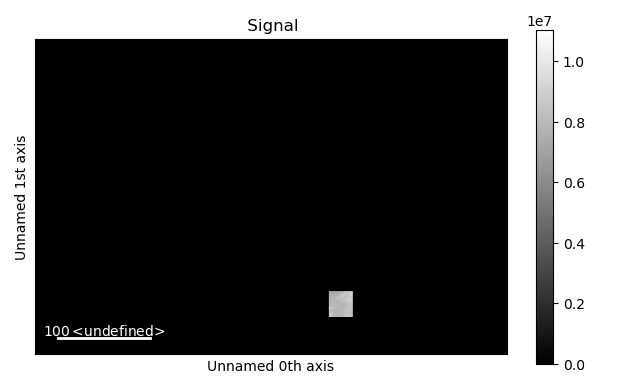

In [29]:
s.isig[:, 0:int(s.axes_manager.signal_shape[-1]/2)].sum(axis=[2,3]).T.plot()
#s.isig[:, 0:int(s.axes_manager.signal_shape[-1]/2)].sum(axis=[2,3]).T.plot(norm='log', cmap='turbo')

Create mask:

In [30]:
mask = s.isig[:, 0:int(s.axes_manager.signal_shape[-1]/2)].sum(axis=[2,3]).T.data

In [31]:
# Set threshold and mask value
thresh = 0
mask_value = 1

mask[mask > thresh] = mask_value

In [32]:
mask.shape

(341, 512)

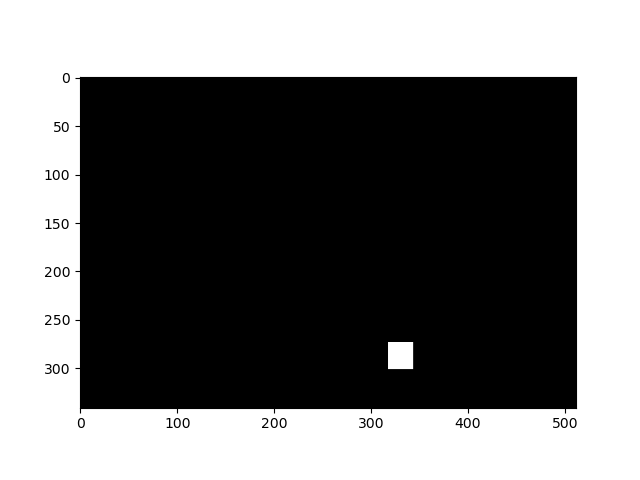

In [33]:
fig, ax = plt.subplots()
ax.imshow(mask, cmap='gray')

In [34]:
# Convert mask top Hyperspy signal
# We transpose it to navigation axes, where we want to crop in this case
mask_signal = hs.signals.Signal2D(mask).T

In [35]:
mask_signal

<BaseSignal, title: , dimensions: (512, 341|)>

In [36]:
s

<EBSD, title: , dimensions: (512, 341|200, 200)>

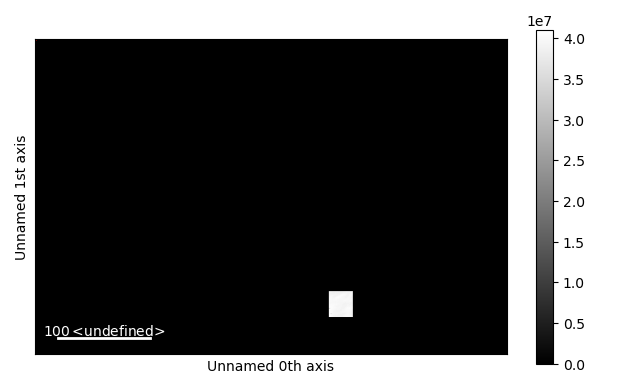

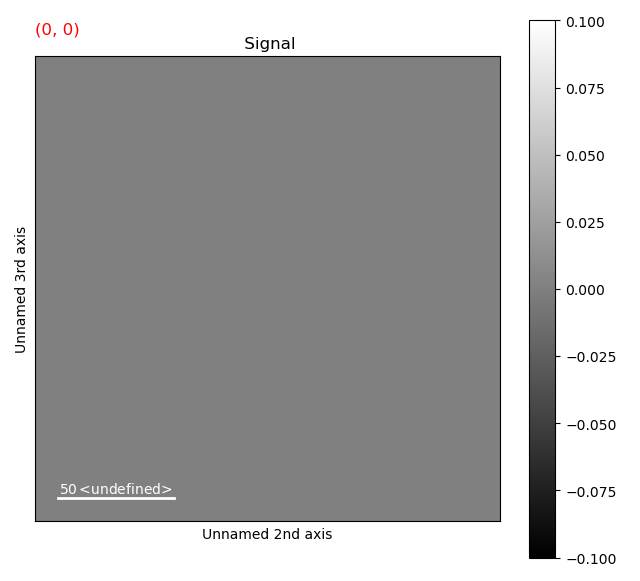

In [73]:
# Multiplying the signals should yield the cropped area
# Use the plot to validate the correct patterns
(s * mask_signal).plot()

If everything looks good, we can finally create the desired signal:

In [37]:
s = s * mask_signal

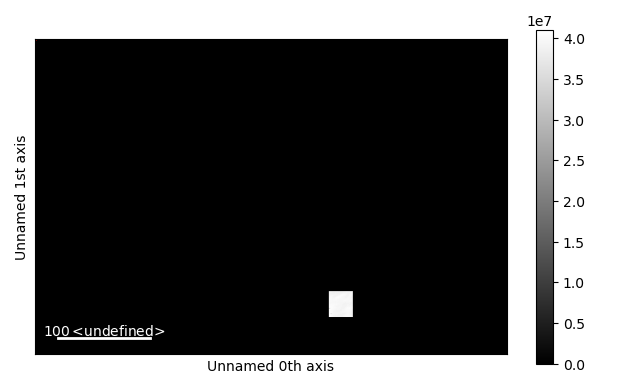

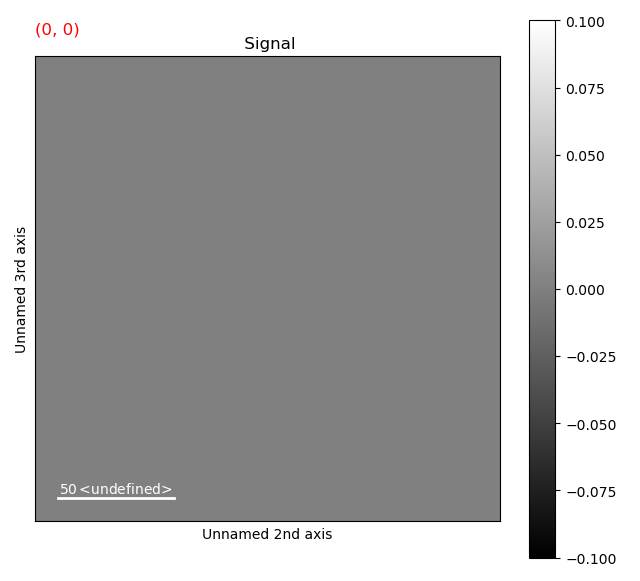

In [38]:
s.plot()

In [39]:
# Set spatial calibration of real-space scan from the SEM overview image
s.axes_manager.navigation_axes[0].units = unit
s.axes_manager.navigation_axes[1].units = unit
s.axes_manager.navigation_axes[0].scale = pixelsize
s.axes_manager.navigation_axes[1].scale = pixelsize

In [ ]:
# Save the patterns as Kikuchipy's h5 / HyperSpy's .hspy

#s.save('EBSD_dataset.hspy', overwrite=True)
s.save('TKD_dataset.hspy', overwrite=True)

**Done! :-)**  
The saved file contains the raw diffraction patterns and one can continue with analysis in kikuchipy/pyxem!  
If an ROI was used, it should also be smaller than the original hdf5 file.